In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt
from pprint import pprint

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, text, inspect, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
base =automap_base()
# reflect the tables
base.prepare(autoload_with=engine)

In [6]:
# View all of the classes that automap found
base.classes.keys()

['station', 'measurement']

In [7]:
# Save references to each table
station = base.classes.station
measure = base.classes.measurement

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
recentData = session.query(measure.date).order_by(measure.date.desc()).first()
recentData


('2017-08-23',)

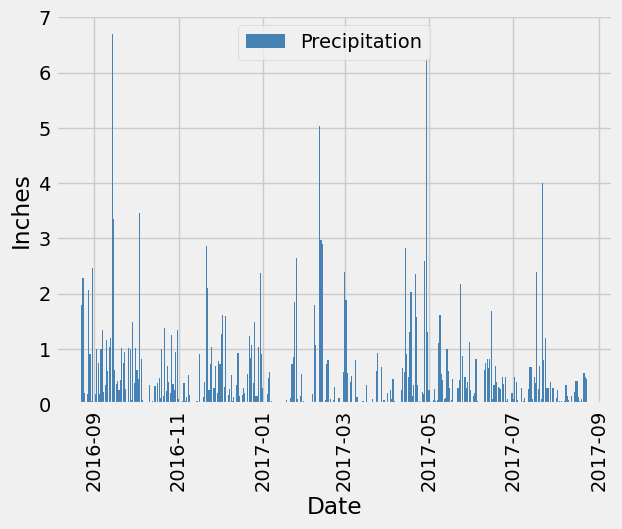

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
dateList = recentData[0].split('-')
year_prior = dt.datetime(int(dateList[0]), int(dateList[1]), int(dateList[2])) - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
with engine.connect() as conn:
    result = conn.execute(text(f'Select date, prcp from measurement')).fetchall()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
prcpDF = pd.DataFrame(result, columns = ['Date','PRCP'])
prcpDF['Date'] = pd.to_datetime(prcpDF['Date'])
prcpDF = prcpDF.loc[prcpDF['Date'] >= year_prior]
prcpDF = prcpDF.dropna()

# Sort the dataframe by date
prcpDF = prcpDF.sort_values(by='Date')

# Use Pandas Plotting with Matplotlib to plot the data
plt.bar(prcpDF['Date'], prcpDF['PRCP'], color='steelblue', label='Precipitation')
plt.xlabel('Date')
plt.xticks(rotation=90)
plt.ylabel('Inches')
plt.legend(loc = 'upper center')
plt.show()

In [11]:
# Use Pandas to calculate the summary statistics for the precipitation data
sumDF = prcpDF['PRCP'].describe()
sumDF


count    2021.000000
mean        0.177279
std         0.461190
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: PRCP, dtype: float64

# Exploratory Station Analysis

In [12]:
# Design a query to calculate the total number of stations in the dataset
with engine.connect() as conn:
    station = conn.execute(text('Select count(station) from station')).fetchall()
    print(station)

[(9,)]


In [13]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
with engine.connect() as conn:
    stations = conn.execute(text('Select station, count(station) from measurement group by station order by count(station) desc')).fetchall()
    pprint(stations)


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]


In [14]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
with engine.connect() as conn:
    temp = conn.execute(text('Select station, tobs from measurement where station = "USC00519281"')).fetchall()

tempDF = pd.DataFrame(temp, columns = ['station','tobs'])
min = tempDF['tobs'].min()
max = tempDF['tobs'].max()
ave = tempDF['tobs'].mean()
tempDF_list = [min, max, ave]
tempDF_list

[54.0, 85.0, 71.66378066378067]

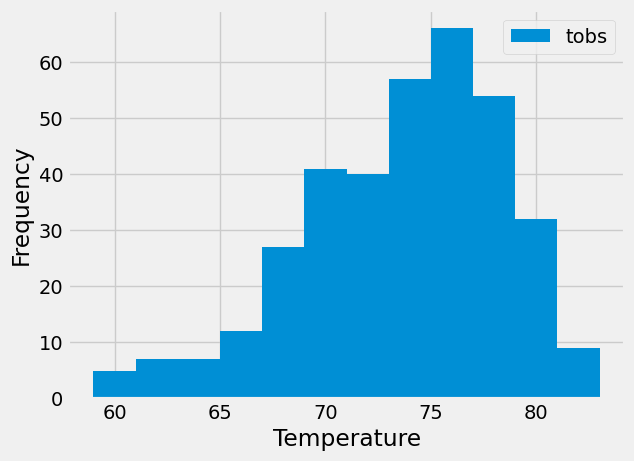

In [15]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
with engine.connect() as conn:
    stationDate = conn.execute(text('Select Date from measurement where station = "USC00519281" order by date desc')).first()
    stationData = conn.execute(text('Select Station, Date, TOBS from measurement where station = "USC00519281" order by date desc')).all()

dateListStation = stationDate[0].split('-')
year_prior_station = dt.datetime(int(dateListStation[0]), int(dateListStation[1]), int(dateListStation[2])) - dt.timedelta(days=365)

stationDF = pd.DataFrame(stationData, columns = ['Station', 'Date','TOBS'])
stationDF['Date'] = pd.to_datetime(stationDF['Date'])
stationDF = stationDF.loc[stationDF['Date'] >= year_prior_station]
stationDF = stationDF.dropna()

plt.hist(stationDF['TOBS'], bins=12, label='tobs')
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.legend(loc = 'upper right')
plt.show()

# Close Session

In [16]:
# Close Session
session.close()